In [165]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import os

In [166]:
os.getcwd()

'/Users/jakobbuchner/AC_Speaker/video_analysis'

In [167]:
data=pd.read_csv('kp_coords/angewinkelt.csv')
data
data=nose_as_origin(data)
data

,frame_count,pose_score,part_names,keypoint_score,x,y,timestamp
0,0,0.485981,nose,0.998596,0.000000,0.000000,0
1,0,0.485981,leftEye,0.999153,22.493046,-18.724090,0
2,0,0.485981,rightEye,0.999037,-24.718709,-16.982078,0
3,0,0.485981,leftEar,0.989831,59.260902,7.194480,0
4,0,0.485981,rightEar,0.963525,-54.085492,6.754109,0
...,...,...,...,...,...,...,...
2817,165,0.000000,rightHip,0.000000,0.000000,0.000000,11
2818,165,0.000000,leftKnee,0.000000,0.000000,0.000000,11
2819,165,0.000000,rightKnee,0.000000,0.000000,0.000000,11
2820,165,0.000000,leftAnkle,0.000000,0.000000,0.000000,11


In [22]:
right_elbows=data[data['part_names']=='rightElbow'][['frame_count','x','y']].rename({'x':'x_elbow','y':'y_elbow'},axis=1)
right_shoulders=data[data['part_names']=='rightShoulder'][['frame_count','x','y']].rename({'x':'x_shoulder','y':'y_shoulder'},axis=1)
right_wrists=data[data['part_names']=='rightWrist'][['frame_count','x','y']].rename({'x':'x_wrist','y':'y_wrist'},axis=1)

In [23]:
left_elbows=data[data['part_names']=='leftElbow'][['frame_count','x','y']].rename({'x':'x_elbow','y':'y_elbow'},axis=1)
left_shoulders=data[data['part_names']=='leftShoulder'][['frame_count','x','y']].rename({'x':'x_shoulder','y':'y_shoulder'},axis=1)
left_wrists=data[data['part_names']=='leftWrist'][['frame_count','x','y']].rename({'x':'x_wrist','y':'y_wrist'},axis=1)

In [24]:
right_arm=right_elbows.merge(right_shoulders, on='frame_count')
right_arm=right_arm.merge(right_wrists, on='frame_count')

In [25]:
left_arm=left_elbows.merge(left_shoulders, on='frame_count')
left_arm=left_arm.merge(left_wrists, on='frame_count')


In [26]:
left_arm['elbow_to_shoulder_x']= left_arm['x_elbow']-left_arm['x_shoulder']
left_arm['elbow_to_shoulder_y']= left_arm['y_elbow']-left_arm['y_shoulder']

left_arm['elbow_to_wrist_x']= left_arm['x_elbow']-left_arm['x_wrist']
left_arm['elbow_to_wrist_y']= left_arm['y_elbow']-left_arm['y_wrist']

left_arm['skalarprod']=left_arm['elbow_to_shoulder_x']*left_arm['elbow_to_wrist_x']+left_arm['elbow_to_shoulder_y']*left_arm['elbow_to_wrist_y']
left_arm['länge_ets']=np.sqrt(left_arm['elbow_to_shoulder_x']**2+left_arm['elbow_to_shoulder_y']**2)
left_arm['länge_etw']=np.sqrt(left_arm['elbow_to_wrist_x']**2+left_arm['elbow_to_wrist_y']**2)

left_arm['winkel']=np.degrees(np.arccos(left_arm['skalarprod']/np.abs(left_arm['länge_etw']*left_arm['länge_ets'])))


In [27]:
right_arm['elbow_to_shoulder_x']= right_arm['x_shoulder']-right_arm['x_elbow']
right_arm['elbow_to_shoulder_y']= right_arm['y_shoulder']-right_arm['y_elbow']

right_arm['elbow_to_wrist_x']= right_arm['x_wrist']-right_arm['x_elbow']
right_arm['elbow_to_wrist_y']= right_arm['y_wrist']-right_arm['y_elbow']

right_arm['skalarprod']=right_arm['elbow_to_shoulder_x']*right_arm['elbow_to_wrist_x']+right_arm['elbow_to_shoulder_y']*right_arm['elbow_to_wrist_y']
right_arm['länge_ets']=np.sqrt(right_arm['elbow_to_shoulder_x']**2+right_arm['elbow_to_shoulder_y']**2)
right_arm['länge_etw']=np.sqrt(right_arm['elbow_to_wrist_x']**2+right_arm['elbow_to_wrist_y']**2)

right_arm['winkel']=np.degrees(np.arccos(right_arm['skalarprod']/np.abs(right_arm['länge_etw']*right_arm['länge_ets'])))


In [28]:
def get_angle(data, vertex, point_a, point_b):
    "Get the angle between the vectors from vertex to point_a and vertex to point_b where coordinates have standard format or nose_origin_format"
    vertex_points=data[data['part_names']==vertex][['frame_count','x','y']].rename({'x':'x_vertex','y':'y_vertex'},axis=1)
    a_points=data[data['part_names']==point_a][['frame_count','x','y']].rename({'x':'x_a','y':'y_a'},axis=1)
    b_points=data[data['part_names']==point_b][['frame_count','x','y']].rename({'x':'x_b','y':'y_b'},axis=1)
    
    table=vertex_points.merge(a_points,on='frame_count')
    table=table.merge(b_points,on='frame_count')
    
    table['v_to_a_x']= table['x_a']-table['x_vertex']
    table['v_to_a_y']= table['y_a']-table['y_vertex']
    table['v_to_b_x']= table['x_b']-table['x_vertex']
    table['v_to_b_y']= table['y_b']-table['y_vertex']

    table['dot_product']=table['v_to_a_x']*table['v_to_b_x'] + table['v_to_a_y']*table['v_to_b_y']
    table['len_vtoa']=np.sqrt(table['v_to_a_x']**2+table['v_to_a_y']**2)
    table['len_vtob']=np.sqrt(table['v_to_b_x']**2+table['v_to_b_y']**2)
    table['angle'] = np.degrees(np.arccos(table['dot_product']/np.abs(table['len_vtoa']*table['len_vtob'])))
    
    table=table[['angle']]
    table.rename({'angle':'angle_at_{}'.format(vertex)},axis=1)
    
    return table

In [29]:
test2=get_angle(data,'leftElbow','leftShoulder','leftWrist')
test2

,angle
0,114.637730
1,107.145453
2,108.964229
3,109.459904
4,110.184082
...,...
161,179.026134
162,178.160130
163,178.835639
164,NaN


In [30]:
def nose_as_origin(data):
    "Transform standard output coordinates to format where nose position is (0/0) coordinate"
    df_nose = (data.loc[data['part_names'] == 'nose', ['frame_count', 'x', 'y']].copy())
    df_nose.columns = ['frame_count', 'x_nose', 'y_nose']
    df = data.merge(df_nose, how='left', on='frame_count')
    df['x'] -= df['x_nose']
    df['y'] -= df['y_nose']
    df = df.drop(['x_nose','y_nose'], axis=1)
    #df.rename(columns={"x": "x_dist_to_nose", "y": "y_dist_to_nose"},inplace=True)
    return df


In [31]:
test=get_angle(data,'rightElbow','rightWrist','rightShoulder')

In [32]:
e=(test['angle']<38) & (test['angle']>36)


In [33]:
data=nose_as_origin(data)

In [34]:
data

,frame_count,pose_score,part_names,keypoint_score,x,y,timestamp
0,0,0.485981,nose,0.998596,0.000000,0.000000,0
1,0,0.485981,leftEye,0.999153,22.493046,-18.724090,0
2,0,0.485981,rightEye,0.999037,-24.718709,-16.982078,0
3,0,0.485981,leftEar,0.989831,59.260902,7.194480,0
4,0,0.485981,rightEar,0.963525,-54.085492,6.754109,0
...,...,...,...,...,...,...,...
2817,165,0.000000,rightHip,0.000000,0.000000,0.000000,11
2818,165,0.000000,leftKnee,0.000000,0.000000,0.000000,11
2819,165,0.000000,rightKnee,0.000000,0.000000,0.000000,11
2820,165,0.000000,leftAnkle,0.000000,0.000000,0.000000,11


In [35]:
def check_angewinkelt(data):
    "return type needs to be list for consecutive functions to work"

    #falls data schon im nosecoords format, egal: nose_as_origin ist idempotent
    data=nose_as_origin(data)

    #get elbow angles
    right_elbow_angle = get_angle(data,'rightElbow','rightWrist','rightShoulder')
    left_elbow_angle = get_angle(data,'leftElbow','leftWrist','leftShoulder')

    #für beträge der x-koordinaten gilt: hip<wrist
    subcond_0 = np.abs(data[data['part_names']=='rightHip']['x'].reset_index(drop=True))<np.abs(data[data['part_names']=='rightWrist']['x'].reset_index(drop=True))

    #für beträge der x-koordinaten gilt: wrist<elbow
    subcond_1 = np.abs(data[data['part_names']=='rightWrist']['x'].reset_index(drop=True))<np.abs(data[data['part_names']=='rightElbow']['x'].reset_index(drop=True))

    #für beträge der x-koordinaten gilt: hip<wrist
    subcond_2 = np.abs(data[data['part_names']=='leftHip']['x'].reset_index(drop=True))<np.abs(data[data['part_names']=='leftWrist']['x'].reset_index(drop=True))

    #für beträge der x-koordinaten gilt: wrist<elbow
    subcond_3 = np.abs(data[data['part_names']=='leftWrist']['x'].reset_index(drop=True))<np.abs(data[data['part_names']=='leftElbow']['x'].reset_index(drop=True))

    #winkel sind in best. bereich
    subcond_4 = (right_elbow_angle<125) & (right_elbow_angle>95)
    subcond_4 = subcond_4['angle']

    #winkel sind in best. bereich
    subcond_5 = (left_elbow_angle<125) & (left_elbow_angle>95)
    subcond_5 = subcond_5['angle']

    #für beträge der x-koordinaten gilt: hip<wrist<elbow
    c = subcond_0 & subcond_1 & subcond_2 & subcond_3 & subcond_4 & subcond_5
    c = c.rename('angewinkelt')
    
    return c

In [36]:
def check_verschränkt(data):
    "return type needs to be list for consecutive functions to work"

    #falls data schon im nosecoords format, egal: nose_as_origin ist idempotent
    data=nose_as_origin(data)

    #get elbow angles
    right_elbow_angle = get_angle(data,'rightElbow','rightWrist','rightShoulder')
    left_elbow_angle = get_angle(data,'leftElbow','leftWrist','leftShoulder')
    
    left_shoulder_angle = get_angle(data,'leftShoulder','leftElbow','leftHip')
    right_shoulder_angle = get_angle(data,'rightShoulder','rightElbow','rightHip')

    #höhenunterschied rightelbow und rightwrist kleiner als 50
    subcond_0 = np.abs((data[data['part_names']=='rightElbow']['y'].reset_index(drop=True))-(data[data['part_names']=='rightWrist']['y'].reset_index(drop=True)))<50
    
    #höhenunterschied rightelbow und rightwrist kleiner als 50
    subcond_1 = np.abs((data[data['part_names']=='leftElbow']['y'].reset_index(drop=True))-(data[data['part_names']=='leftWrist']['y'].reset_index(drop=True)))<50

    #rightwrist näher an leftelbow als an rightelbow
    subcond_2 = np.abs((data[data['part_names']=='rightElbow']['x'].reset_index(drop=True))-(data[data['part_names']=='rightWrist']['x'].reset_index(drop=True)))>np.abs((data[data['part_names']=='rightWrist']['x'].reset_index(drop=True))-(data[data['part_names']=='leftElbow']['x'].reset_index(drop=True)))

    #so wie sc2 nur für andere seite
    subcond_3 = np.abs((data[data['part_names']=='leftElbow']['x'].reset_index(drop=True))-(data[data['part_names']=='leftWrist']['x'].reset_index(drop=True)))>np.abs((data[data['part_names']=='leftWrist']['x'].reset_index(drop=True))-(data[data['part_names']=='rightElbow']['x'].reset_index(drop=True)))

    #spitze winkel im ellbogen
    subcond_4 = (right_elbow_angle<100) 
    subcond_4 = subcond_4['angle']

    #winkel sind in best. bereich
    subcond_5 = (left_elbow_angle<100) 
    subcond_5 = subcond_5['angle']
    
    #winkel sind in best. bereich
    subcond_6 = (left_shoulder_angle<35) 
    subcond_6 = subcond_6['angle']
    
    #winkel sind in best. bereich
    subcond_7 = (right_shoulder_angle<35) 
    subcond_7 = subcond_7['angle']

    c = subcond_0 & subcond_1 & subcond_2 & subcond_3 & subcond_4 & subcond_5 & subcond_6 & subcond_7
    c = c.rename_axis("verschränkt")
    
    return c

In [37]:
def check_handgelenkgriff(data):
    "return type needs to be list for consecutive functions to work"

    #falls data schon im nosecoords format, egal: nose_as_origin ist idempotent
    data=nose_as_origin(data)

    #get elbow angles
    right_elbow_angle = get_angle(data,'rightElbow','rightWrist','rightShoulder')
    left_elbow_angle = get_angle(data,'leftElbow','leftWrist','leftShoulder')
    
    left_shoulder_angle = get_angle(data,'leftShoulder','leftElbow','leftHip')
    right_shoulder_angle = get_angle(data,'rightShoulder','rightElbow','rightHip')

    #höhenunterschied elbows kleiner als 30
    subcond_0 = np.abs((data[data['part_names']=='rightElbow']['y'].reset_index(drop=True))-(data[data['part_names']=='leftElbow']['y'].reset_index(drop=True)))<30
    
    #höhenunterschied wrists kleiner als 50
    subcond_1 = np.abs((data[data['part_names']=='leftWrist']['y'].reset_index(drop=True))-(data[data['part_names']=='leftWrist']['y'].reset_index(drop=True)))<50

    #für beträge der x-koordinaten gilt: wrist<Hip
    subcond_2 = np.abs(data[data['part_names']=='rightWrist']['x'].reset_index(drop=True))<np.abs(data[data['part_names']=='rightHip']['x'].reset_index(drop=True))

    #für beträge der x-koordinaten gilt: wrist<Hip
    subcond_3 = np.abs(data[data['part_names']=='leftWrist']['x'].reset_index(drop=True))<np.abs(data[data['part_names']=='leftHip']['x'].reset_index(drop=True))
    
    #stumpfe winkel im ellbogen
    subcond_4 = (right_elbow_angle>100) 
    subcond_4 = subcond_4['angle']

    #winkel sind in best. bereich
    subcond_5 = (left_elbow_angle>100) 
    subcond_5 = subcond_5['angle']
    
    #winkel sind in best. bereich
    subcond_6 = (left_shoulder_angle<35) 
    subcond_6 = subcond_6['angle']
    
    #winkel sind in best. bereich
    subcond_7 = (right_shoulder_angle<35) 
    subcond_7 = subcond_7['angle']

    c = subcond_0 & subcond_1 & subcond_2 & subcond_3 & subcond_4 & subcond_5 & subcond_6 & subcond_7
    c = c.rename_axis("handgelenke hängend umgriffen")
    
    return c

In [38]:
def get_blocks(_list, drop_blocks=1, include_False_blocks=False):
    "get consecutive blocks, drop (meaning invert) blocks of length 1. Warning: Multiple execution will invert longer blocks"
    _list=list(_list)
    
    #get blocks/sequences of consecutive true/false elements
    block_list = []
    i=0
    for key, iter in itertools.groupby(_list):
        block_length=len(list(iter))
        block_list.append((key, block_length,i))
        i += block_length
    print("1",block_list)
    
    
    if (include_False_blocks==False):
        block_list = [element for element in block_list if element[0]==True]

    return block_list





In [39]:
    #find single values (blocks of length "drop_blocks") 
    singles = [element for element in answer if element[1]==drop_blocks]
    print("singles",singles)
    # invert single values
    for element in singles:
        block_list[element[1]]= not (block_list[element[1]])
    print("2",block_list)

singles []


NameError: name 'block_list' is not defined

In [40]:
# get consecutive blocks 

answer = []
i=0
for key, iter in itertools.groupby(c):
    block_length=len(list(iter))
    answer.append((key, block_length,i))
    i += block_length
answer

NameError: name 'c' is not defined

In [41]:
# suche alle blöcke wo wahr
selection = [element for element in answer if element[0]==True]
print(selection)

[]


In [42]:
df = pd.DataFrame(e, columns=['a', 'length', 'start_frame'])

In [43]:
frame_to_second=data[['frame_count','timestamp']]
prev=-1
for element in e:
    second=frame_to_second[frame_to_second['frame_count']== element[2]].iloc[0][1]
    if (prev!=second):
        print("Beidseitig in die Hüften gestützte Arme ab Sekunde ", second)
    prev=second

TypeError: 'bool' object is not subscriptable

In [44]:
se=data[['frame_count','timestamp']]
avg_fps=se.iloc[-1][0]/se.iloc[-1][1]

In [45]:
a=check_angewinkelt(data)
v=check_verschränkt(data)
aa=check_handgelenkgriff(data)

In [63]:
f=pd.concat([a,v,aa],axis=1).to_numpy().transpose()
bool_array_for_plot=f
f.shape

(3, 166)

In [64]:
import matplotlib.pyplot as plt
import matplotlib.colors

In [66]:
def plot(bool_array_for_plot,labels_for_plot):
    colmap = matplotlib.colors.ListedColormap(np.random.random((21,3)))
    colmap.colors[0] = [0,0,0]
    data_color = (1 + np.arange(f.shape[0]))[:, None] * bool_array_for_plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(data_color, aspect='auto', cmap=colmap)
    ax.set_yticks(np.arange(len(labels_for_plot)))
    ax.set_yticklabels(labels_for_plot)
    


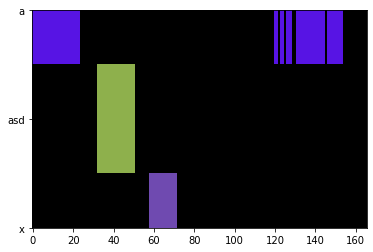

In [68]:
plot(bool_array_for_plot,labels_for_plot)

In [67]:
labels_for_plot=['a','asd','x']

In [76]:
data

,frame_count,pose_score,part_names,keypoint_score,x,y,timestamp
0,0,0.485981,nose,0.998596,0.000000,0.000000,0
1,0,0.485981,leftEye,0.999153,22.493046,-18.724090,0
2,0,0.485981,rightEye,0.999037,-24.718709,-16.982078,0
3,0,0.485981,leftEar,0.989831,59.260902,7.194480,0
4,0,0.485981,rightEar,0.963525,-54.085492,6.754109,0
...,...,...,...,...,...,...,...
2817,165,0.000000,rightHip,0.000000,0.000000,0.000000,11
2818,165,0.000000,leftKnee,0.000000,0.000000,0.000000,11
2819,165,0.000000,rightKnee,0.000000,0.000000,0.000000,11
2820,165,0.000000,leftAnkle,0.000000,0.000000,0.000000,11


In [86]:
data=nose_as_origin(data)
df_prev=data.copy()
df_prev['frame_count']=df_prev['frame_count']+1
df_prev=df_prev.drop(['pose_score','keypoint_score'],axis=1)
df_prev.rename(columns={"x": "x_dist_to_nose_in_prev_frame", "y": "y_dist_to_nose_in_prev_frame"},inplace=True)
df_prev=data.merge(df_prev, on=['frame_count','part_names'])

df_prev['x_movement']=df_prev['x']-df_prev['x_dist_to_nose_in_prev_frame']
df_prev['y_movement']=df_prev['y']-df_prev['y_dist_to_nose_in_prev_frame']
df_prev['movement_vector_length']=((df_prev['x_movement']**2)+(df_prev['y_movement']**2))**(1/2)

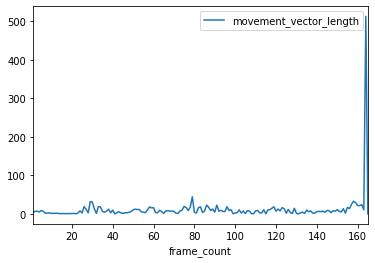

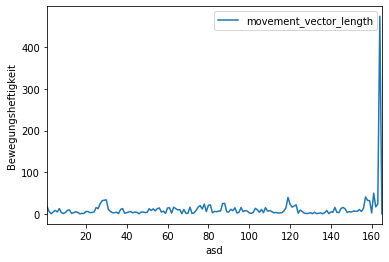

In [123]:
df_prev[df_prev['part_names']=='rightElbow'].plot(x='frame_count', y='movement_vector_length')
df_prev[df_prev['part_names']=='leftElbow'].plot(x='frame_count', y='movement_vector_length')

plt.ylabel('Bewegungsheftigkeit')
plt.xlabel('asd')

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
ax.set_xticks([0.15, 0.68, 0.97])
plt.show()

In [91]:
df_prev.tail(20)

,frame_count,pose_score,part_names,keypoint_score,x,y,timestamp_x,x_dist_to_nose_in_prev_frame,y_dist_to_nose_in_prev_frame,timestamp_y,x_movement,y_movement,movement_vector_length
2785,164,0.0,rightKnee,0.0,0.0,0.0,11,-7.778701,762.187851,10,7.778701,-762.187851,762.227543
2786,164,0.0,leftAnkle,0.0,0.0,0.0,11,114.311715,756.037437,10,-114.311715,-756.037437,764.630482
2787,164,0.0,rightAnkle,0.0,0.0,0.0,11,-3.471846,750.382033,10,3.471846,-750.382033,750.390065
2788,165,0.0,nose,0.0,0.0,0.0,11,0.000000,0.000000,11,0.000000,0.000000,0.000000
2789,165,0.0,leftEye,0.0,0.0,0.0,11,0.000000,0.000000,11,0.000000,0.000000,0.000000
2790,165,0.0,rightEye,0.0,0.0,0.0,11,0.000000,0.000000,11,0.000000,0.000000,0.000000
2791,165,0.0,leftEar,0.0,0.0,0.0,11,0.000000,0.000000,11,0.000000,0.000000,0.000000
2792,165,0.0,rightEar,0.0,0.0,0.0,11,0.000000,0.000000,11,0.000000,0.000000,0.000000
2793,165,0.0,leftShoulder,0.0,0.0,0.0,11,0.000000,0.000000,11,0.000000,0.000000,0.000000
2794,165,0.0,rightShoulder,0.0,0.0,0.0,11,0.000000,0.000000,11,0.000000,0.000000,0.000000


In [162]:
def plota(df_prev):

    #diese informationen sind notwendig, um die achsenbeschriftung von frames zu sekunden zu ändern
    maxframe=df_prev['frame_count'].max()
    maxsec=df_prev['timestamp_x'].max()
    secs=df_prev['timestamp_x'].unique()

    #informationen für den ersten und zweiten teilgraphen
    leftwrist=df_prev[df_prev['part_names']=='leftWrist']
    leftwrist=leftwrist.set_index('frame_count')
    leftwrist=leftwrist['movement_vector_length']
    leftwrist=leftwrist.rename(columns={"'movement_vector_length'": "a"})

    rightwrist=df_prev[df_prev['part_names']=='rightWrist']
    rightwrist=rightwrist.set_index('frame_count')
    rightwrist=rightwrist['movement_vector_length']
    rightwrist=rightwrist.rename(columns={'movement_vector_length': 'eta'})

    #plotten der beiden teilgraphen
    ax = leftwrist.plot(legend=True,label="Links")
    rightwrist.plot(ax=ax, legend=True,label="Rechts")

    #x-achsen beschriftung: zuerst wird die position der ticks, dann ihr inhalt festgelegt
    ax.set_xticks(np.arange(0,maxframe,int(maxframe/maxsec)), minor=False)
    ax.set_xticklabels(secs, fontdict=None, minor=False)

    #keine beschriftung an der y achse
    ax.set_yticks([], minor=False)

    ax.set_xlabel('Sekunde')
    ax.set_ylabel('Bewegungsheftigkeit')


In [152]:
df_prev['timestamp_x'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

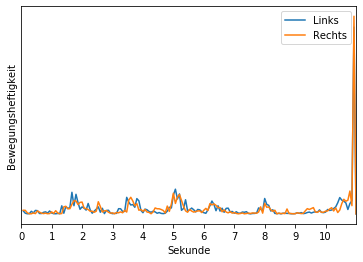

In [163]:
plota(df_prev)

In [168]:
data

,frame_count,pose_score,part_names,keypoint_score,x,y,timestamp
0,0,0.485981,nose,0.998596,0.000000,0.000000,0
1,0,0.485981,leftEye,0.999153,22.493046,-18.724090,0
2,0,0.485981,rightEye,0.999037,-24.718709,-16.982078,0
3,0,0.485981,leftEar,0.989831,59.260902,7.194480,0
4,0,0.485981,rightEar,0.963525,-54.085492,6.754109,0
...,...,...,...,...,...,...,...
2817,165,0.000000,rightHip,0.000000,0.000000,0.000000,11
2818,165,0.000000,leftKnee,0.000000,0.000000,0.000000,11
2819,165,0.000000,rightKnee,0.000000,0.000000,0.000000,11
2820,165,0.000000,leftAnkle,0.000000,0.000000,0.000000,11


In [171]:
from jakobsfuncs import *
found_poses=check_angewinkelt(data) & check_handgelenkgriff(data) & check_verschränkt(data)

In [172]:
e

0       True
1       True
2       True
3       True
4       True
       ...  
161    False
162    False
163    False
164    False
165    False
Name: angewinkelt, Length: 166, dtype: bool